In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap as sp

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from catboost import CatBoostClassifier

from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc
from sklearn.metrics import f1_score

from interpret.glassbox import ExplainableBoostingClassifier
from interpret.data import ClassHistogram
from interpret import show

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [3]:
df = pd.read_csv('diabetes_binary_5050split_health_indicators_BRFSS2015.csv')
df.head(5)

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


In [4]:
print(f"Dataset Shape: {df.shape}")
 
summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
summary = summary.reset_index()
summary['Name'] = summary['index']
summary['Missing'] = df.isnull().sum().values
summary['PercMissing'] = df.isnull().sum().values / df.isnull().count().values
summary['Uniques'] = df.nunique().values
summary['Data type'] = df.dtypes.values
 
print('**Variable Description of  data:**')
summary

Dataset Shape: (70692, 22)
**Variable Description of  data:**


,index,dtypes,Name,Missing,PercMissing,Uniques,Data type
0,Diabetes_binary,float64,Diabetes_binary,0,0.0,2,float64
1,HighBP,float64,HighBP,0,0.0,2,float64
2,HighChol,float64,HighChol,0,0.0,2,float64
3,CholCheck,float64,CholCheck,0,0.0,2,float64
4,BMI,float64,BMI,0,0.0,80,float64
5,Smoker,float64,Smoker,0,0.0,2,float64
6,Stroke,float64,Stroke,0,0.0,2,float64
7,HeartDiseaseorAttack,float64,HeartDiseaseorAttack,0,0.0,2,float64
8,PhysActivity,float64,PhysActivity,0,0.0,2,float64
9,Fruits,float64,Fruits,0,0.0,2,float64


In [5]:
target_column = ["Diabetes_binary"]
 
numerical_column = ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth','Age', 'Education', 'Income']
 
categorical_columns = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 
                    'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']

df[numerical_column] = df[numerical_column].astype('float')
df[categorical_columns] = df[categorical_columns].fillna(-1).astype('int').astype('category')

df = df[target_column + numerical_column + categorical_columns]

df[target_column] = df.dropna(subset=target_column)[target_column].astype('int')

In [6]:
df.describe()

,Diabetes_binary,BMI,GenHlth,MentHlth,PhysHlth,Age,Education,Income
count,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000
mean,0.500000,29.856985,2.837082,3.752037,5.810417,8.584055,4.920953,5.698311
std,0.500004,7.113954,1.113565,8.155627,10.062261,2.852153,1.029081,2.175196
min,0.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,25.000000,2.000000,0.000000,0.000000,7.000000,4.000000,4.000000
50%,0.500000,29.000000,3.000000,0.000000,0.000000,9.000000,5.000000,6.000000
75%,1.000000,33.000000,4.000000,2.000000,6.000000,11.000000,6.000000,8.000000
max,1.000000,98.000000,5.000000,30.000000,30.000000,13.000000,6.000000,8.000000


In [7]:
#Train/test split
 
X = df.drop(target_column, axis=1)
y = df[target_column]
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 
n_train=y.size
n_test=y_test.size
 
n,p=X.shape
n_classes= np.unique(y).size
 
#matrice des probas
lb = LabelBinarizer().fit(y)
Y_train = lb.transform(y_train) 
Y_test = lb.transform(y_test) 
 
print("Shape of train X,y,Y: ",X_train.shape, y_train.shape, Y_train.shape)
print("Shape of test X,y,Y: ",X_test.shape, y_test.shape, Y_test.shape)
print("Number of classes: ", n_classes)

Shape of train X,y,Y:  (56553, 21) (56553, 1) (56553, 1)
Shape of test X,y,Y:  (14139, 21) (14139, 1) (14139, 1)
Number of classes:  2


In [8]:
#Verif ratio:
 
Balance_train = np.unique(y_train, return_counts=True)
Prop_train = Balance_train[1]/np.sum(Balance_train[1])
Ratio_train = Balance_train[1]/Balance_train[1][[np.argmax(Balance_train[1])]]
 
Balance_test = np.unique(y_test, return_counts=True)
Prop_test = Balance_test[1]/np.sum(Balance_test[1])
Ratio_test = Balance_test[1]/Balance_test[1][[np.argmax(Balance_train[1])]]
 
print("Balance_train:", Balance_train)
print("Balance_test:", Balance_test)
print("-"*80)
print("Prop_train:", Prop_train)
print("Prop_test:", Prop_test)
print("-"*80)
print("Ratio_train:", Ratio_train)
print("Ratio_test:", Ratio_test)

Balance_train: (array([0, 1]), array([28256, 28297], dtype=int64))
Balance_test: (array([0, 1]), array([7090, 7049], dtype=int64))
--------------------------------------------------------------------------------
Prop_train: [0.49963751 0.50036249]
Prop_test: [0.50144989 0.49855011]
--------------------------------------------------------------------------------
Ratio_train: [0.99855108 1.        ]
Ratio_test: [1.00581643 1.        ]


In [9]:
#Train model
clf_catboost = CatBoostClassifier(cat_features = sorted([X.columns.get_loc(col) for col in categorical_columns]))
clf_catboost = clf_catboost.fit(X_train, y_train, verbose = 100, eval_set = (X_test, y_test))

Learning rate set to 0.085855
0:	learn: 0.6618769	test: 0.6619360	best: 0.6619360 (0)	total: 171ms	remaining: 2m 50s
100:	learn: 0.4926986	test: 0.4986827	best: 0.4986827 (100)	total: 3.35s	remaining: 29.8s
200:	learn: 0.4837470	test: 0.4980330	best: 0.4980330 (200)	total: 6.83s	remaining: 27.2s
300:	learn: 0.4762596	test: 0.4982614	best: 0.4979377 (223)	total: 9.69s	remaining: 22.5s
400:	learn: 0.4695976	test: 0.4988021	best: 0.4979377 (223)	total: 12.3s	remaining: 18.3s
500:	learn: 0.4645651	test: 0.4995216	best: 0.4979377 (223)	total: 14.9s	remaining: 14.8s
600:	learn: 0.4594465	test: 0.5005202	best: 0.4979377 (223)	total: 17.7s	remaining: 11.7s
700:	learn: 0.4548846	test: 0.5011373	best: 0.4979377 (223)	total: 20.9s	remaining: 8.91s
800:	learn: 0.4502950	test: 0.5019255	best: 0.4979377 (223)	total: 29.1s	remaining: 7.23s
900:	learn: 0.4456610	test: 0.5029318	best: 0.4979377 (223)	total: 38.1s	remaining: 4.18s
999:	learn: 0.4418896	test: 0.5035031	best: 0.4979377 (223)	total: 46.2s	

In [10]:
#Result model
Y_hat_train = clf_catboost.predict_proba(X_train)
Y_hat_test = clf_catboost.predict_proba(X_test)

In [11]:
#Loss
print("Train loss: ", log_loss(Y_train, Y_hat_train))
print("Test loss: ", log_loss(Y_test, Y_hat_test))
 
print("Test loss (random): ", log_loss(Y_test, np.ones((n_test,2))*0.5))

Train loss:  0.48190184445481815
Test loss:  0.49793773645471007
Test loss (random):  0.6931471805599453


AUC PR (CatBoost):  0.8097761000423804
AUC PR (Random):  0.49855010962585755

AUC ROC (CatBoost):  0.8331751385275867
AUC ROC (Random):  0.5


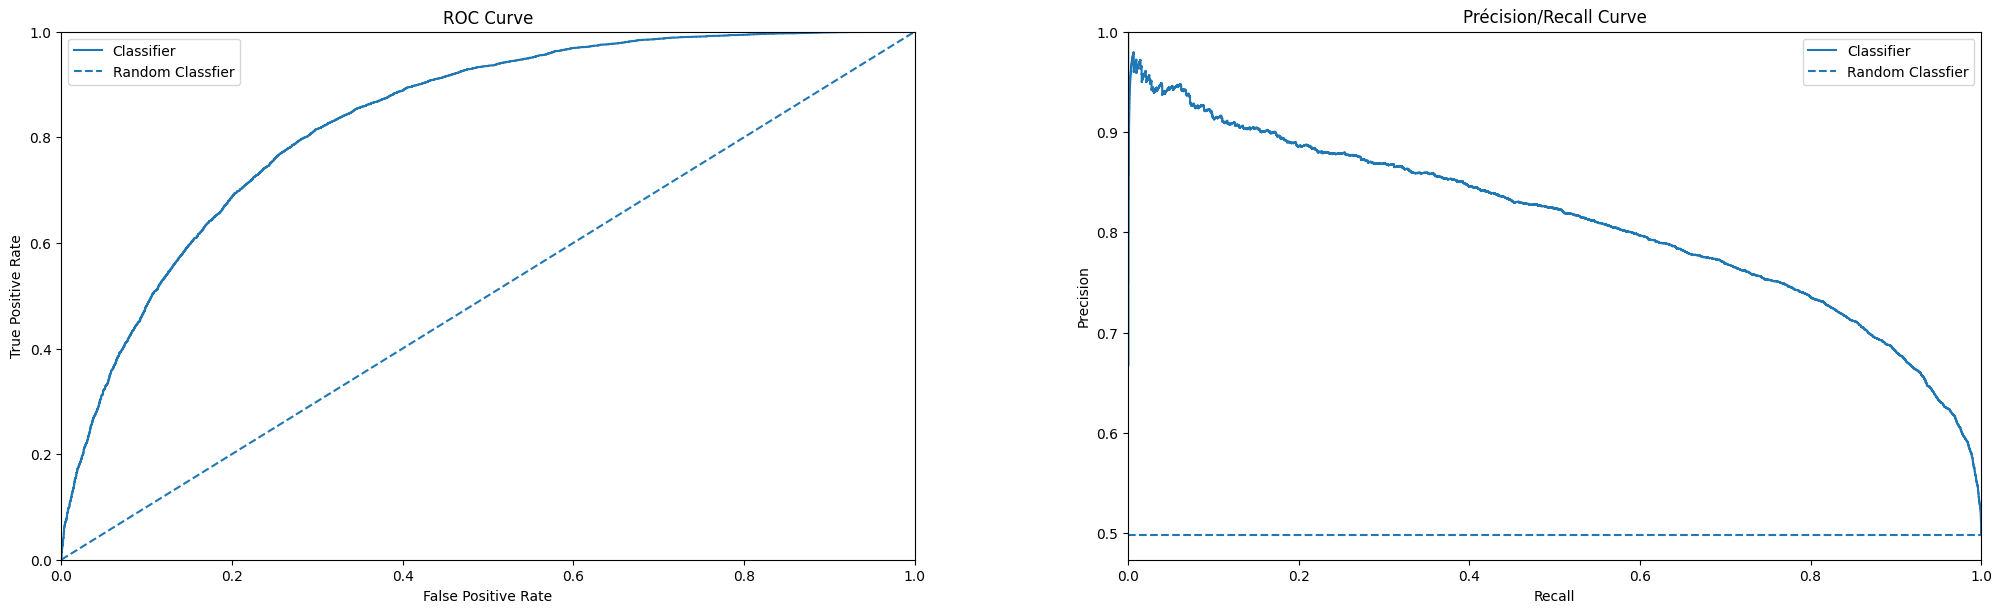

In [12]:
precision, recall, thresholds = precision_recall_curve(y_test, Y_hat_test[:,1])
fpr, tpr, thresholds = roc_curve(y_test, Y_hat_test[:,1])
 
fig, (ax1, ax0) = plt.subplots(nrows=1,ncols=2)
 
display = PrecisionRecallDisplay(precision= precision, recall= recall)
display.plot(ax = ax0, label = "Classifier") 
ax0.axhline(y=Balance_test[1][1]/(Balance_test[1][0] + Balance_test[1][1]), linestyle = "--", label = 'Random Classfier')
ax0.legend()
ax0.set_xlim(0,1)
ax0.set_ylim(Balance_test[1][1]/(Balance_test[1][0] + Balance_test[1][1])*0.95,1)
ax0.set_title("Précision/Recall Curve")
 
display = RocCurveDisplay(fpr= fpr, tpr= tpr)
display.plot(ax = ax1, label = "Classifier")
ax1.axline((0, 0), slope=1, linestyle = "--", label = 'Random Classfier')
ax1.legend()
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_title("ROC Curve")
 
plt.subplots_adjust(left=-1, bottom=-1, right=2, top=0.1, wspace=0.25, hspace=0.5)
 
print("AUC PR (CatBoost): ", auc(recall, precision))
print("AUC PR (Random): ", Balance_test[1][1]/(Balance_test[1][0] + Balance_test[1][1]))
print("")
print("AUC ROC (CatBoost): ", auc(fpr, tpr))
print("AUC ROC (Random): ", 0.5)

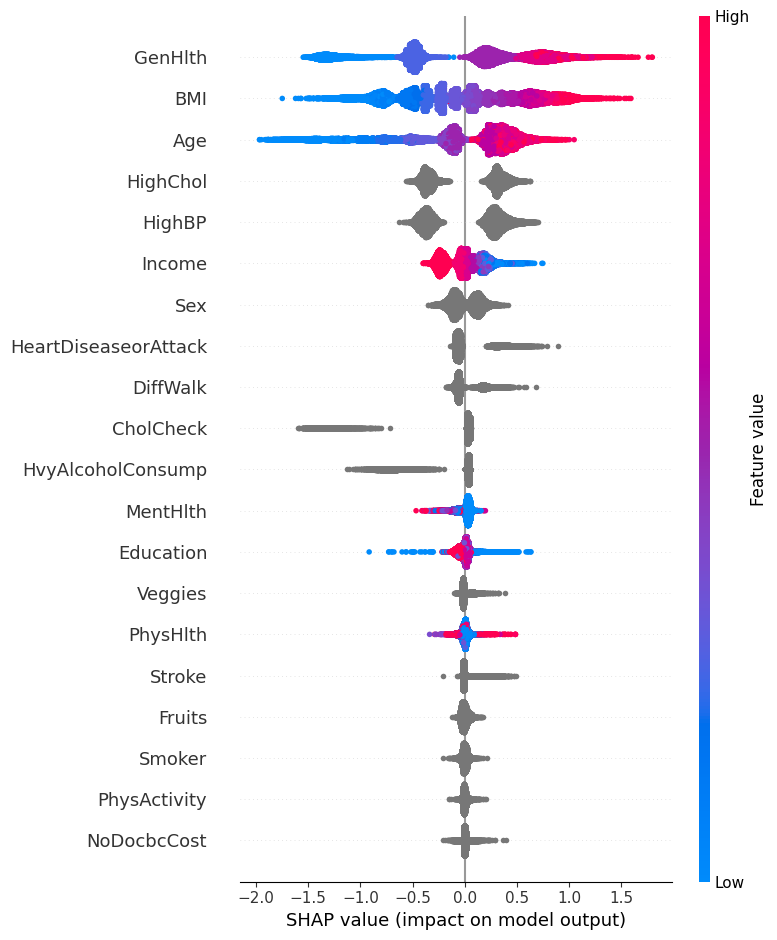

In [13]:
explainer = sp.TreeExplainer(clf_catboost)
shap_values = explainer.shap_values(X_train)
 
sp.summary_plot(shap_values, X_train)

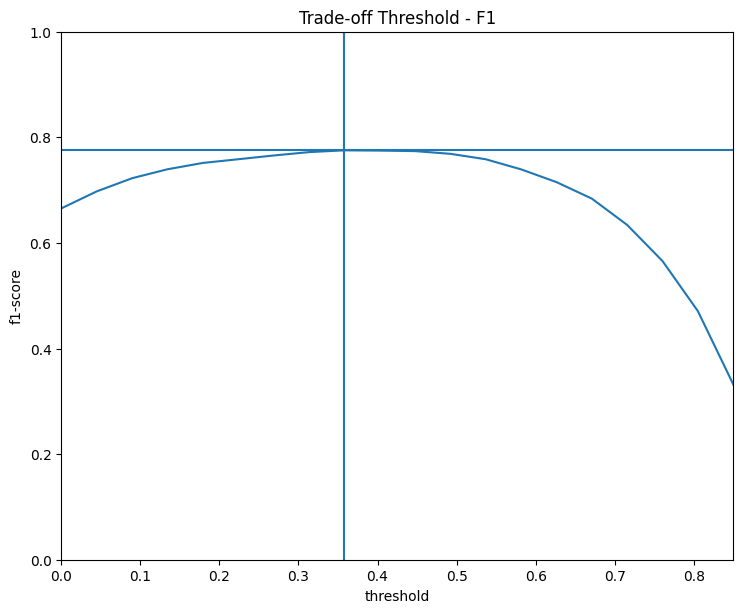

In [14]:
#Should be CV
p_max = 0.85
threshold = np.linspace(0, p_max, 20)
 
f1 = np.zeros(threshold.size) 
for i in range(threshold.size):
    y_hat_test_ = Y_hat_test[:,1] >= threshold[i]
    f1[i] = f1_score(y_test, y_hat_test_)
 
argmax = np.argmax(f1)
p_star = threshold[argmax]
 
plt.plot(threshold,f1)
plt.title("Trade-off Threshold - F1")
plt.xlabel("threshold")
plt.ylabel("f1-score")
plt.xlim(0,p_max)
plt.ylim(0,1)
plt.axvline(p_star)
plt.axhline(f1[argmax])
 
plt.subplots_adjust(left=-1, bottom=-1, right=0.05, top=0.1, wspace=0.25, hspace=0.5)

In [15]:
threshold = 0.5 #p_star
y_hat_train = Y_hat_train[:,1] >= threshold
y_hat_test = Y_hat_test[:,1] >= threshold

In [16]:
Balance_hat_test = np.unique(y_hat_test, return_counts=True)
Balance_test = np.unique(y_test, return_counts=True)
 
print("Taille échantillon:", y_test.size,"\n\n")
print("     y_pred    y_true","\n")
print("0:  ", Balance_hat_test[1][0],"  ", Balance_test[1][0])
print("1:  ", Balance_hat_test[1][1],"  ", Balance_test[1][1])

Taille échantillon: 14139 


     y_pred    y_true 

0:   6427    7090
1:   7712    7049


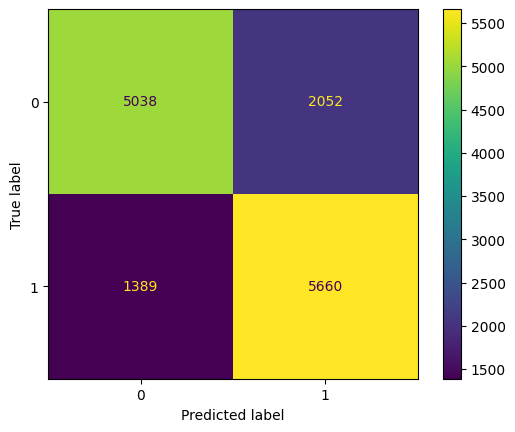

In [17]:
fig = ConfusionMatrixDisplay(confusion_matrix(y_test, y_hat_test), display_labels = (["0", "1"]) )
fig.plot()

In [18]:
print(classification_report(y_test, y_hat_test, target_names = ["0", "1"]))

              precision    recall  f1-score   support

           0       0.78      0.71      0.75      7090
           1       0.73      0.80      0.77      7049

    accuracy                           0.76     14139
   macro avg       0.76      0.76      0.76     14139
weighted avg       0.76      0.76      0.76     14139



In [19]:
clf_ebm = ExplainableBoostingClassifier()
clf_ebm.fit(X_train, y_train)

ExplainableBoostingClassifier()

In [20]:
Y_hat_train = clf_ebm.predict_proba(X_train)
Y_hat_test = clf_ebm.predict_proba(X_test)

In [21]:
#Loss
print("Train loss: ", log_loss(Y_train, Y_hat_train))
print("Test loss: ", log_loss(Y_test, Y_hat_test))
 
print("Test loss (random): ", log_loss(Y_test,np.ones((n_test,2))*0.5))

Train loss:  0.5002053151236552
Test loss:  0.5003825187707563
Test loss (random):  0.6931471805599453


AUC PR (EBM):  0.8078002426126709
AUC PR (Random):  0.49855010962585755

AUC ROC (EBM):  0.8317023931412212
AUC ROC (Random):  0.5


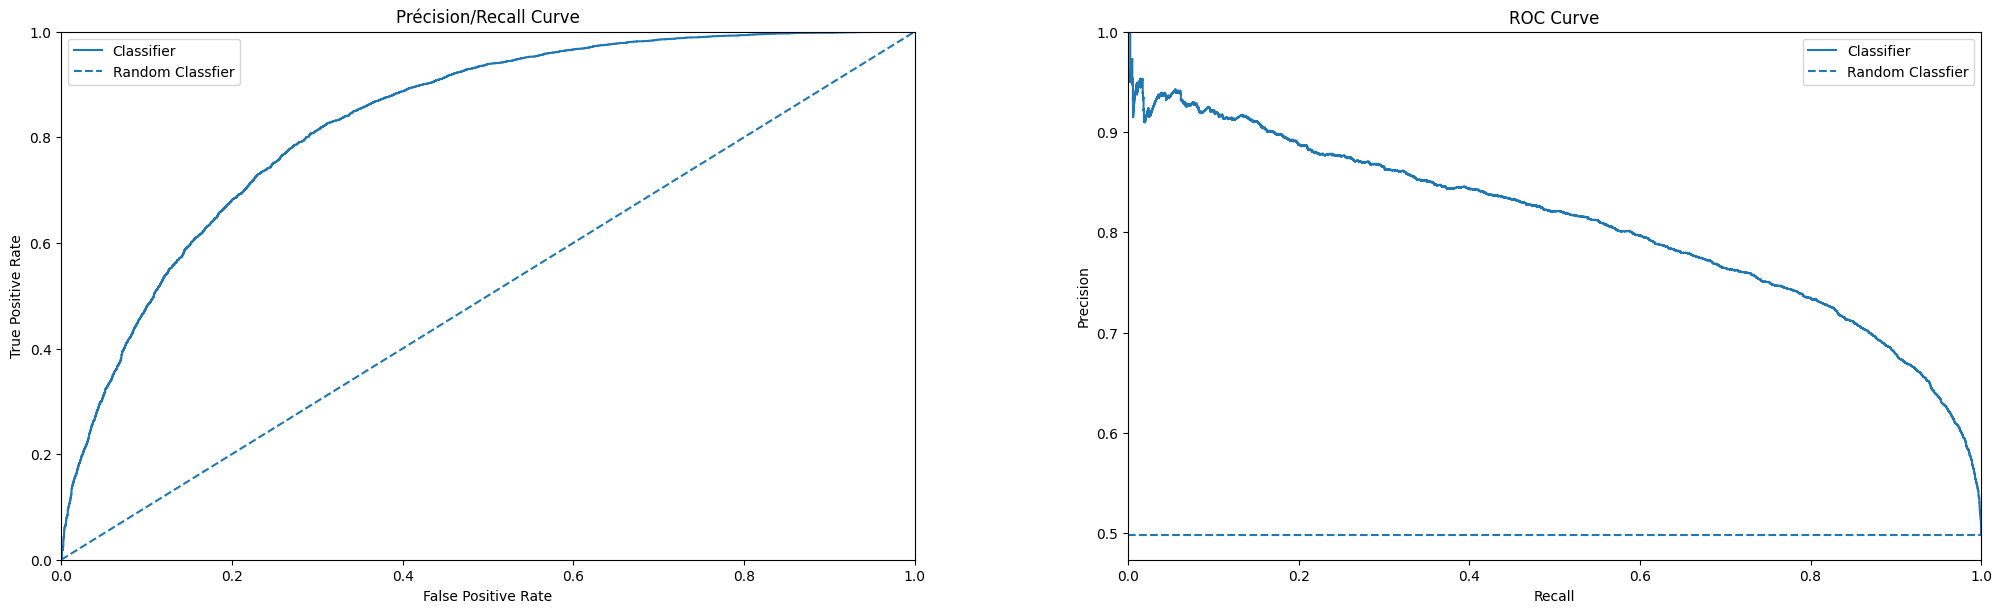

In [22]:
precision, recall, thresholds = precision_recall_curve(y_test, Y_hat_test[:,1])
fpr, tpr, thresholds = roc_curve(y_test, Y_hat_test[:,1])
 
fig, (ax1, ax0) = plt.subplots(nrows=1,ncols=2)
 
display = PrecisionRecallDisplay(precision= precision, recall= recall)
display.plot(ax = ax0, label = "Classifier") 
ax0.axhline(y=Balance_test[1][1]/(Balance_test[1][0] + Balance_test[1][1]), linestyle = "--", label = 'Random Classfier')
ax0.legend()
ax0.set_xlim(0,1)
ax0.set_ylim(Balance_test[1][1]/(Balance_test[1][0] + Balance_test[1][1])*0.95,1)
ax0.set_title("ROC Curve")
 
display = RocCurveDisplay(fpr= fpr, tpr= tpr)
display.plot(ax = ax1, label = "Classifier")
ax1.axline((0, 0), slope=1, linestyle = "--", label = 'Random Classfier')
ax1.legend()
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_title("Précision/Recall Curve")
 
plt.subplots_adjust(left=-1, bottom=-1, right=2, top=0.1, wspace=0.25, hspace=0.5)
 
print("AUC PR (EBM): ", auc(recall, precision))
print("AUC PR (Random): ", Balance_test[1][1]/(Balance_test[1][0] + Balance_test[1][1]))
print("")
print("AUC ROC (EBM): ", auc(fpr, tpr))
print("AUC ROC (Random): ", 0.5)

In [23]:
clf_ebm_explain = clf_ebm.explain_global(name='EBM')

In [24]:
show(clf_ebm.explain_global(name='EBM'))

C:\Users\Vfarc\anaconda3\envs\Test\Lib\site-packages\interpret\visual\_udash.py:117: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



<!-- http://127.0.0.1:7001/2407416038352/ -->